In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils as utils
from torch.utils.data import Dataset, DataLoader
import torchvision as vision
from torchvision import transforms, utils, datasets

import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import os
from skimage import io, transform
from PIL import Image

In [ ]:
trainLabels = pd.read_csv("LOC_train_solution.csv")

In [ ]:
trainLabels['PredictionString'] = trainLabels['PredictionString'].str.split(n=1).str.get(0)

In [ ]:
uniqueCategories = trainLabels['PredictionString'].unique()

In [ ]:
categoryMap = {i : j for j, i in enumerate(uniqueCategories, 0)}

In [ ]:
categoryMap

In [ ]:
trainLabels['PredictionString'] = trainLabels['PredictionString'].map(categoryMap).astype(np.int32)

In [ ]:
trainLabels['ImageId'].iloc[0].split('_')[0]

In [ ]:
np.array([trainLabels['PredictionString'].iloc[0]])

In [2]:
# instantiate data class

class ImageNetData(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): csv_file containing labels
            root_dir (string): directory containing all data
            transform (callable, optional): optional transforms to be applied to an image
        """
        # process labels
        self.trainLabels = pd.read_csv(csv_file) # read label file
        self.trainLabels['PredictionString'] = self.trainLabels['PredictionString'].str.split(n=1).str.get(0) # process so only category labels remain
        uniqueCategories = self.trainLabels['PredictionString'].unique() # obtain unique category values
        categoryMap = {i : j for j, i in enumerate(uniqueCategories, 0)} # create mapping to category indices
        self.trainLabels['PredictionString'] = self.trainLabels['PredictionString'].map(categoryMap).astype(np.int32) # map labels to category indices
        
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.trainLabels)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_folder = self.trainLabels['ImageId'].iloc[idx].split('_')[0]
        img_name = self.trainLabels['ImageId'].iloc[idx] + '.JPEG'
        img_path = os.path.join(self.root_dir, img_folder, img_name)
        
        image = Image.open(img_path)
        image = image.convert('RGB')
        label = np.array([self.trainLabels['PredictionString'].iloc[idx]])
        
        if self.transform:
            image = self.transform(image)
        
        sample = {'image': image, 'label': label}
        
        return sample

<Figure size 432x288 with 0 Axes>

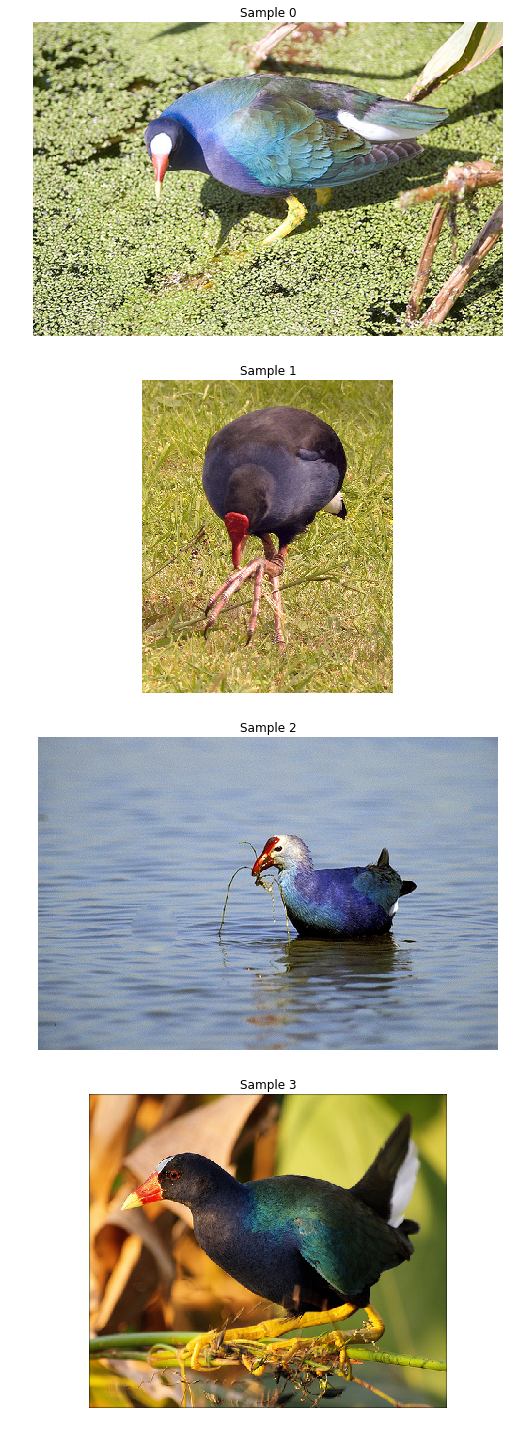

In [5]:
imageData = ImageNetData(csv_file = 'LOC_train_solution.csv', root_dir = 'ILSVRC/Data/CLS-LOC/train')

fig = plt.figure()
plt.figure(figsize=(20, 20))

# show images
for i in range(4):
    sample = imageData[i]
    
    #print(i, sample['image'].shape, sample['label'].shape)
    
    ax = plt.subplot(4, 1, i+1)
    plt.tight_layout()
    ax.set_title('Sample {}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'])

In [6]:
# create image transformations
train_transform = transforms.Compose([transforms.Resize(size=(336, 336)),
                                      transforms.RandomRotation(degrees=20),
                                      transforms.RandomCrop(size=224),
                                      transforms.RandomVerticalFlip(p=0.5),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor(),
                                      transforms.RandomErasing(scale=(0.02, 0.1))])

test_transform = transforms.Compose([transforms.Resize(size=(336, 336)),
                                     transforms.RandomCrop(size=224),
                                     transforms.ToTensor()])

0 torch.Size([3, 224, 224]) (1,)
1 torch.Size([3, 224, 224]) (1,)
2 torch.Size([3, 224, 224]) (1,)
3 torch.Size([3, 224, 224]) (1,)


<Figure size 432x288 with 0 Axes>

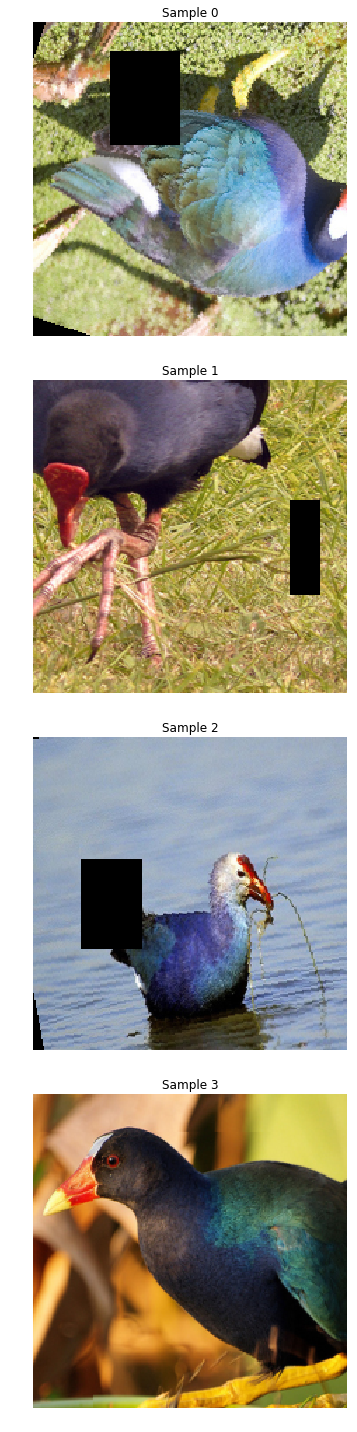

In [7]:
# see the effects of transformation
#imageData = ImageNetData(csv_file = 'LOC_train_solution.csv', root_dir = 'ILSVRC/Data/CLS-LOC/train')

fig = plt.figure()
plt.figure(figsize=(20, 20))

# show images
for i in range(4):
    sample = imageData[i]
    
    transformed_image = train_transform(sample['image'])
    
    print(i, transformed_image.shape, sample['label'].shape)
    
    ax = plt.subplot(4, 1, i+1)
    plt.tight_layout()
    ax.set_title('Sample {}'.format(i))
    ax.axis('off')
    plt.imshow(transformed_image.numpy().transpose(1, 2, 0))

In [10]:
trainLabelFile = 'LOC_train_solution.csv'
train_dir = 'ILSVRC/Data/CLS-LOC/train'
ImageNetDataset = ImageNetData(csv_file = trainLabelFile, root_dir = train_dir, transform = train_transform)
train_loader = DataLoader(ImageNetDataset, batch_size=128, shuffle=True, num_workers=16)

In [ ]:
for i in range(len(ImageNetDataset)):
    img = ImageNetDataset[i]
    if img['image'].shape[0] != 3:
        print("ERROR")


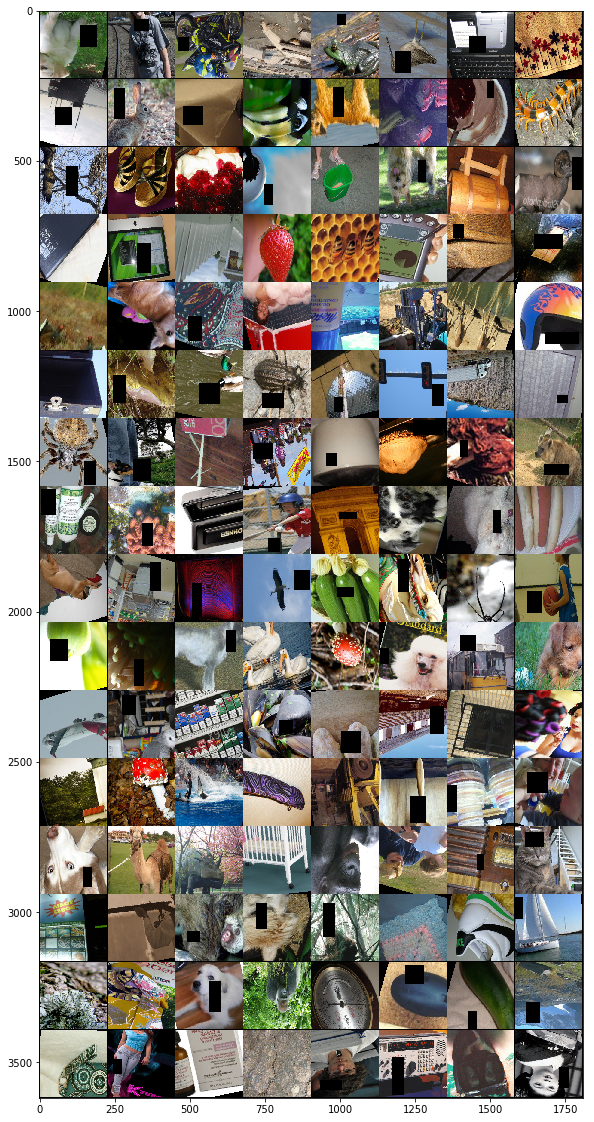

In [11]:
image_batch = next(iter(train_loader))
grid = utils.make_grid(image_batch['image'])
plt.figure(figsize=(20, 20))
plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [ ]:
# define network
class deepNet(nn.Module):
    def __init__(self):
        super(deepNet, self).__init__()
        self.conv